<a href="https://colab.research.google.com/github/weibb123/FaceMaskDetection/blob/main/%5BProject%5D_Face_Mask_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Data/Library

In [2]:
# import data
from google.colab import files
uploaded = files.upload()

Saving FaceMaskDetection.zip to FaceMaskDetection.zip


In [ ]:
!unzip FaceMaskDetection.zip

In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from zipfile import ZipFile
import os
from torch.optim import lr_scheduler
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
import torch
import torch.nn.functional as F                          # Functions like ReLU
import torch.optim as optim                              # Optimizers like Adam
import torch.nn as nn                                    # Neural Network Modules
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm                                    # To print the Progress bar


In [ ]:
!pip install albumentations==0.4.6
import albumentations 
from albumentations.pytorch import ToTensorV2 # Coverting image to Tensor

# Create/Process/Load Data

<br> Notice annotation is in xml and images in png, so we will install xmltodict to treat xml as JSON files

In [6]:
os.getcwd()

'/content'

In [7]:
!pip install xmltodict

In [8]:
import xmltodict

In [9]:
# Because we dont have train/test folder in dataset, we need to add images and annotation first into a list first.


images_path = "/content/images"
ann_path = "/content/annotations"
image_list = os.listdir(images_path)  # this gives list of images in images_path
ann_list = os.listdir(ann_path) # this gives list of annotation in ann_path

# list comprehension
img = [ (images_path + '/' + image_list[i]) for i in range(len(image_list)) if image_list[i].endswith('.png')]
ann = [ (ann_path + '/' + ann_list[i]) for i in range(len(ann_list)) if ann_list[i].endswith('.xml')]
print(img)


['/content/images/maksssksksss660.png', '/content/images/maksssksksss530.png', '/content/images/maksssksksss442.png', '/content/images/maksssksksss188.png', '/content/images/maksssksksss86.png', '/content/images/maksssksksss802.png', '/content/images/maksssksksss486.png', '/content/images/maksssksksss628.png', '/content/images/maksssksksss480.png', '/content/images/maksssksksss482.png', '/content/images/maksssksksss597.png', '/content/images/maksssksksss768.png', '/content/images/maksssksksss167.png', '/content/images/maksssksksss187.png', '/content/images/maksssksksss626.png', '/content/images/maksssksksss664.png', '/content/images/maksssksksss303.png', '/content/images/maksssksksss432.png', '/content/images/maksssksksss494.png', '/content/images/maksssksksss465.png', '/content/images/maksssksksss811.png', '/content/images/maksssksksss538.png', '/content/images/maksssksksss787.png', '/content/images/maksssksksss771.png', '/content/images/maksssksksss585.png', '/content/images/maksssks

In [10]:
# Next we will try to count number of annotation we have.
path_file = '/content/annotations'
lst = []
for j in img[:]:
  with open(path_file + j[15:-4]+".xml") as fd:  # ignore last 4 characters to find each image to find each annotation
    document = xmltodict.parse(fd.read()) # Parse the given XML input and convert it into a dictionary.

  temp = document["annotation"]["object"]
  
  if type(temp) == list: 
    for i in range(len(temp)):
        lst.append(temp[i]["name"])
  else:
        lst.append(temp["name"])

# counter will create a dictionary for us and allows us to count types of mask wearing pictures
type_mask = Counter(lst).keys()
val = Counter(lst).values()
print(type_mask)
print(val)

dict_keys(['without_mask', 'with_mask', 'mask_weared_incorrect'])
dict_values([717, 3232, 123])


# Visualization
### Notice we have three target classes for us to predict
<b><br> with_mask, without_mask, mask_weared_incorrect </b></br>

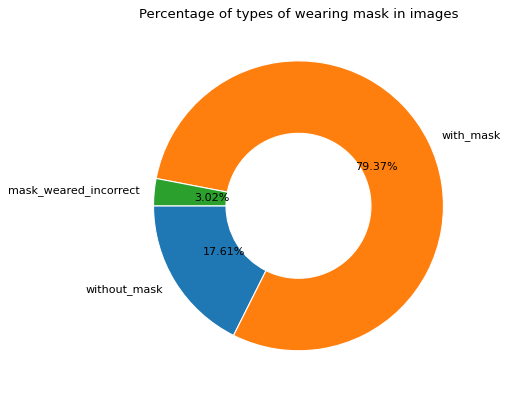

In [11]:
plt.figure(figsize= (10,6), dpi=80)
plt.title("Percentage of types of wearing mask in images")
plt.pie(val, wedgeprops=dict(width=0.5, edgecolor='w') ,
        labels=type_mask, radius=1, startangle = 180, autopct='%1.2f%%')
plt.show()

Credit goes to https://www.kaggle.com/sandhyakrishnan02 Sandhya Krishnan for showing how to detect mask wearing in images 

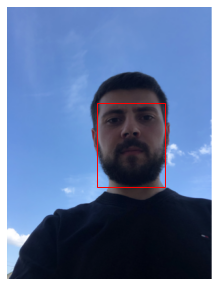

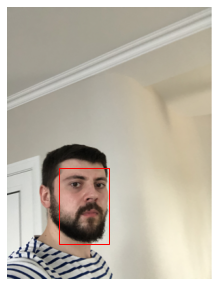

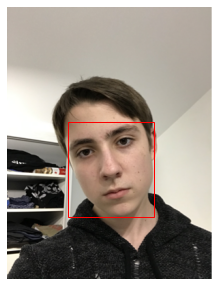

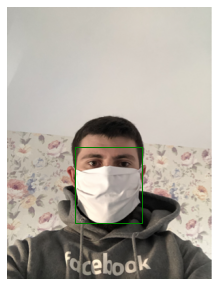

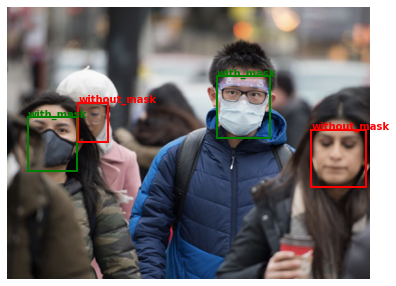

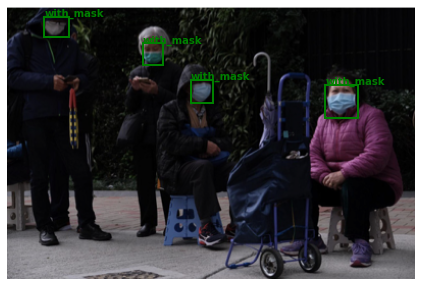

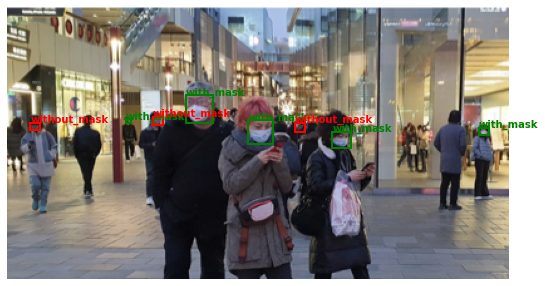

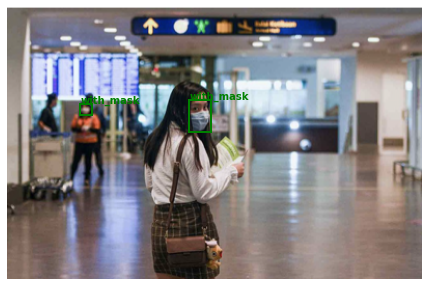

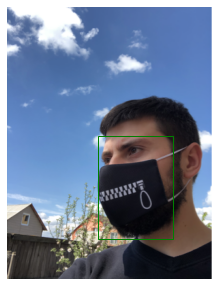

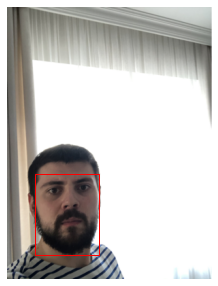

In [64]:
import matplotlib.patches as mpatches
path_image = '/content/images/'

def show_img(image):
  with open(path_file + '/' + image[:-4] + ".xml") as fd:  # ignore last 4 characters to find each image to find each annotation
    document = xmltodict.parse(fd.read())        # Parse the given XML input and convert it into a dictionary.
  image = plt.imread( os.path.join(path_image + image) )
  fig,ax=plt.subplots(1)
  ax.axis("off")
  fig.set_size_inches(10,5)
  temp = document["annotation"]["object"]
  if type(temp) == list:
     for i in range(len(temp)):
       # images with_mask
       if temp[i]["name"]=="with_mask":
         x,y,w,h=list(map(int,temp[i]["bndbox"].values()))
         mpatch=mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor='g',facecolor="none",lw=2,)
         ax.add_patch(mpatch)
         rx, ry = mpatch.get_xy()
         ax.annotate("with_mask", (rx, ry), color='green', weight='bold', fontsize=10, ha='left', va='baseline')
         
       # images without_mask
       if temp[i]["name"]=="without_mask":
                x,y,w,h=list(map(int,temp[i]["bndbox"].values()))     
                mpatch=mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor='r',facecolor="none",lw=2,)
                ax.add_patch(mpatch)
                rx, ry = mpatch.get_xy()
                ax.annotate("without_mask", (rx, ry), color='red', weight='bold', fontsize=10, ha='left', va='baseline')
      # image with incorrect mask wear
       if temp[i]["name"]=="mask_weared_incorrect":
                x,y,w,h=list(map(int,temp[i]["bndbox"].values()))
                mpatch=mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor='y',facecolor="none",lw=2,)
                ax.add_patch(mpatch)
                rx, ry = mpatch.get_xy()
                ax.annotate("mask_weared_incorrect", (rx, ry), color='yellow', weight='bold', fontsize=10, ha='left', va='baseline')
  else:
    x,y,w,h=list(map(int,temp["bndbox"].values()))
    edgecolor={"with_mask":"g","without_mask":"r","mask_weared_incorrect":"y"}
    mpatch=mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor=edgecolor[temp["name"]],facecolor="none",)
  ax.imshow(image)
  ax.add_patch(mpatch)



fun_images = image_list.copy()
for images_present in range(10):
  show_img(fun_images[images_present])





# Preprocess data to feed in NeuralNet

In [65]:
print(temp)
# notice temp has name, mask_weared_incorrect, bndbox, xmin, ymin, xmax, ymax

[OrderedDict([('name', 'with_mask'), ('pose', 'Unspecified'), ('truncated', '0'), ('occluded', '0'), ('difficult', '0'), ('bndbox', OrderedDict([('xmin', '17'), ('ymin', '104'), ('xmax', '55'), ('ymax', '137')]))]), OrderedDict([('name', 'with_mask'), ('pose', 'Unspecified'), ('truncated', '0'), ('occluded', '0'), ('difficult', '0'), ('bndbox', OrderedDict([('xmin', '52'), ('ymin', '78'), ('xmax', '86'), ('ymax', '111')]))]), OrderedDict([('name', 'mask_weared_incorrect'), ('pose', 'Unspecified'), ('truncated', '0'), ('occluded', '0'), ('difficult', '0'), ('bndbox', OrderedDict([('xmin', '72'), ('ymin', '56'), ('xmax', '101'), ('ymax', '93')]))]), OrderedDict([('name', 'with_mask'), ('pose', 'Unspecified'), ('truncated', '0'), ('occluded', '0'), ('difficult', '0'), ('bndbox', OrderedDict([('xmin', '142'), ('ymin', '73'), ('xmax', '177'), ('ymax', '108')]))]), OrderedDict([('name', 'with_mask'), ('pose', 'Unspecified'), ('truncated', '0'), ('occluded', '0'), ('difficult', '0'), ('bndbox

In [72]:
# data dictionary for target_classes
target_classes = {'without_mask': 0, 'mask_weared_incorrect': 1, 'with_mask': 2}

# we will write a function that feed in image_list as parameter in order to normalize data, the function is similar to what we wrote above
print(image_list)

transform = transforms.Compose([transforms.Resize((226,226)), # resize image to 226 x 226 then conver to tensor
                                
                                 transforms.ToTensor()])
def data(dataset):
  image_tensor = []
  label_tensor = []
  for i, j in enumerate(dataset): # for loop that get each image in the dataset
    with open(path_file + '/' + j[:-4] + '.xml') as fd: # get rid of last 4 characters
      document = xmltodict.parse(fd.read()) # this is a dictionary
    
    if type(document["annotation"]["object"]) == list:
      temp=document["annotation"]["object"]
      for k in range(len(temp)):
        x,y,w,h=list(map(int,temp[k]["bndbox"].values()))
        label = target_classes[temp[k]["name"]]
        image = transforms.functional.crop(Image.open(path_image+j).convert("RGB"),y,x,h-y,w-x)
        image_tensor.append(transform(image))
        label_tensor.append(torch.tensor(label))
    

    elif type(document["annotation"]["object"]) != list:
      temp = document["annotation"]["object"]
      x,y,w,h = list(map(int,temp["bndbox"].values()))
      label = target_classes[temp["name"]]
      image=transforms.functional.crop(Image.open(path_image+j).convert("RGB"), y,x,h-y,w-x)
      image_tensor.append(transform(image))
      label_tensor.append(torch.tensor(label))

  dataSet = [[k,l] for k,l in zip(image_tensor,label_tensor)]
  return tuple(dataSet)




Dataset = data(image_list)



['maksssksksss660.png', 'maksssksksss530.png', 'maksssksksss442.png', 'maksssksksss188.png', 'maksssksksss86.png', 'maksssksksss802.png', 'maksssksksss486.png', 'maksssksksss628.png', 'maksssksksss480.png', 'maksssksksss482.png', 'maksssksksss597.png', 'maksssksksss768.png', 'maksssksksss167.png', 'maksssksksss187.png', 'maksssksksss626.png', 'maksssksksss664.png', 'maksssksksss303.png', 'maksssksksss432.png', 'maksssksksss494.png', 'maksssksksss465.png', 'maksssksksss811.png', 'maksssksksss538.png', 'maksssksksss787.png', 'maksssksksss771.png', 'maksssksksss585.png', 'maksssksksss661.png', 'maksssksksss652.png', 'maksssksksss170.png', 'maksssksksss479.png', 'maksssksksss780.png', 'maksssksksss392.png', 'maksssksksss146.png', 'maksssksksss366.png', 'maksssksksss508.png', 'maksssksksss370.png', 'maksssksksss505.png', 'maksssksksss89.png', 'maksssksksss218.png', 'maksssksksss622.png', 'maksssksksss45.png', 'maksssksksss166.png', 'maksssksksss558.png', 'maksssksksss828.png', 'maksssksksss

In [73]:
# Splitting 80% into training 20% testing

print('Length of dataset is', len(Dataset))

training_size = int(len(Dataset)*0.8) # 80% training data
test_size = len(Dataset) - training_size # 20% testing data
print('size of training set is', training_size)
print('size of testing set is', test_size)


Length of dataset is 4072
size of training set is 3257
size of testing set is 815


In [138]:
# this code will split dataset randomly
trainset,testset = torch.utils.data.random_split(Dataset,[training_size,test_size])

In [139]:
training_dl = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)
testing_dl = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=True)

# Training

In [ ]:
model = models.resnet34(pretrained=True)

n_inputs=model.fc.in_features
last_layer=nn.Linear(n_inputs,3)

model.fc.out_features=last_layer
print('reinitialize model with output features as 3 :', model.fc.out_features)

model.cuda() # set model to be in GPU 

In [153]:
# Hyperparameters
learning_rate = 1e-4
num_epochs = 10


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [155]:
for epoch in range(num_epochs):
   training_loss = []
   for batch_idx, (DATA, targets) in tqdm(enumerate(training_dl), total = len(training_dl)): # tqdm to display the bar
     data, targets = DATA.cuda(), targets.cuda()     

     # backward
     optimizer.zero_grad()
     output = model(DATA.cuda()) # data needs to be in GPU in order to be train
     loss = criterion(output, targets)
     training_loss.append(loss.item())

     loss.backward()
     optimizer.step() #gradient descent or adam step

   scheduler.step()
   print(f'Epoch {epoch}, train loss: {np.mean(training_loss):.4f}')
     
    

print('\nFinished Training')

100%|██████████| 204/204 [00:42<00:00,  4.76it/s]


Epoch 0, train loss: 0.4922


100%|██████████| 204/204 [00:43<00:00,  4.68it/s]


Epoch 1, train loss: 0.1670


100%|██████████| 204/204 [00:42<00:00,  4.76it/s]


Epoch 2, train loss: 0.1289


100%|██████████| 204/204 [00:42<00:00,  4.78it/s]


Epoch 3, train loss: 0.0787


100%|██████████| 204/204 [00:42<00:00,  4.78it/s]


Epoch 4, train loss: 0.0541


100%|██████████| 204/204 [00:42<00:00,  4.75it/s]


Epoch 5, train loss: 0.0417


100%|██████████| 204/204 [00:42<00:00,  4.79it/s]


Epoch 6, train loss: 0.0271


100%|██████████| 204/204 [00:42<00:00,  4.79it/s]


Epoch 7, train loss: 0.0258


100%|██████████| 204/204 [00:42<00:00,  4.79it/s]


Epoch 8, train loss: 0.0238


100%|██████████| 204/204 [00:42<00:00,  4.78it/s]

Epoch 9, train loss: 0.0224

Finished Training


In [156]:
def evaluate_performance(dataset, model):
    correct = 0
    samples = 0
    model.eval()
    
    with torch.no_grad(): # when evaluating, no gradient
        for x, y in dataset:
            x = x.cuda()
            y = y.cuda()
            output = model(x)
            _, predictions = output.max(1)
            correct += (predictions == y).sum()
            samples += predictions.size(0)
            
    model.train()
    return correct / samples

In [159]:
a = evaluate_performance(training_dl, model) # feed in training_dl to see training accuracy
print('This is training accuracy', a)

This is training accuracy tensor(0.9969, device='cuda:0')


In [160]:
b = evaluate_performance(testing_dl, model) # feed in training_dl to see test accuracy
print('This is test accuracy', b)

This is test accuracy tensor(0.9742, device='cuda:0')
